<a href="https://colab.research.google.com/github/jnrkufuor/apollo/blob/Ernest/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Packagaes

In [125]:
!pip install squarify

import pandas as pd
import numpy as np
import math
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})
import squarify
import statistics
#from google.colab import drive
#drive.mount('/content/drive')

tqdm.pandas()

C:\Users\jaycu\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#2. Load data

##2.1 Load News Data

In [126]:
df_links = pd.read_csv('../data/df_links_2011_2015.csv')
print(len(df_links.index))

#hyperparamaters
weight_criteria = 6

1591


##2.2 Load Financial data

In [127]:
df_prices =  pd.read_csv('../data/price_corr.csv')
df_vol =  pd.read_csv('../data/volume_corr.csv')

df_finance_nds = pd.DataFrame(columns = ["from", "to", "weight"])

df_prices = df_prices.drop(df_prices.columns[0], axis=1)
df_prices.index = df_prices.columns

df_vol = df_vol.drop(df_vol.columns[0], axis=1)
df_vol.index = df_vol.columns

##2.3 Find Unique Pairs from Correlation Coefficient

In [128]:
# Get correlation pairs for Price and Volume
df_corr_price = df_prices[abs(df_prices) >= 0.0001].stack().reset_index()
df_corr_vol = df_vol[abs(df_vol) >= 0.0001].stack().reset_index()

#Take out lower triangle 
#for price
df_corr_price  = df_corr_price[df_corr_price['level_0'].astype(str)!=df_corr_price['level_1'].astype(str)]
df_corr_price['ordered-cols'] = df_corr_price.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#for volume
df_corr_vol  = df_corr_vol[df_corr_vol['level_0'].astype(str)!=df_corr_vol['level_1'].astype(str)]
df_corr_vol['ordered-cols'] = df_corr_vol.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)

#Remove duplicates and exclude self-correlated values
#for price
df_corr_price = df_corr_price.drop_duplicates(['ordered-cols'])
df_corr_price.reset_index(drop=True, inplace=True)
df_corr_price.drop(['ordered-cols'], axis=1, inplace=True)

#for volume
df_corr_vol = df_corr_vol.drop_duplicates(['ordered-cols'])
df_corr_vol.reset_index(drop=True, inplace=True)
df_corr_vol.drop(['ordered-cols'], axis=1, inplace=True)

#rename columns
df_corr_price.columns = ["from","to","correlation"]
df_corr_vol.columns = ["from","to","correlation"]

#3. Subset data

In [129]:
#Subset mews data. Count all links and store under weight column
df_links = df_links.groupby(['from', 'to']).size().reset_index()
df_links.rename(columns={0: 'weight'}, inplace=True)
df_links.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Frequency heatmap for Comention Matrix')

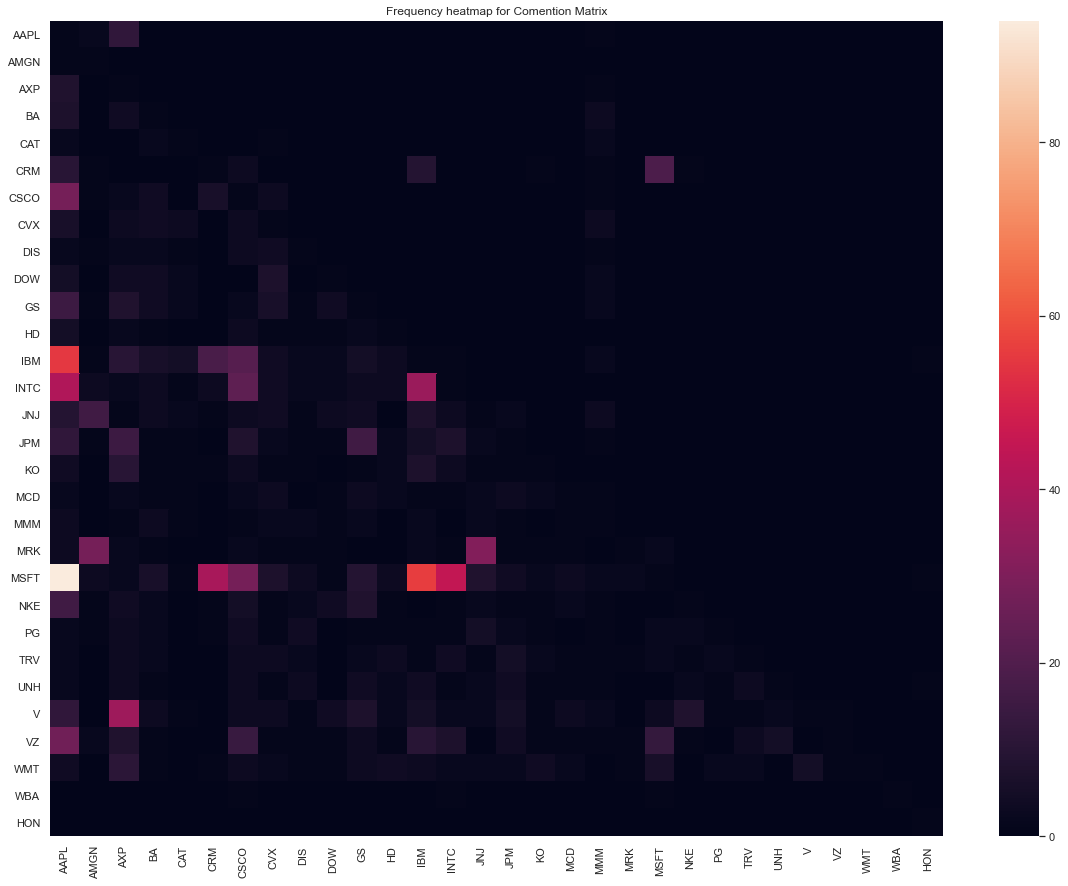

In [130]:
sns.set(rc={'figure.figsize':(20,15)})

#Build Co-mention Matrix
df_links[['from', 'to', 'weight']].sort_values('weight', ascending=False)
col=[]

#Extract Unique Columns
for row in df_links.iterrows():
    if row[1]['from'] not in col:
        col.append(row[1]['from'])
    if row[1]['to'] not in col:
        col.append(row[1]['to'])

df_matrix = pd.DataFrame(0,columns =col,index=col)

for row in df_links.iterrows():
    df_matrix[row[1]['from']][row[1]['to']] = row[1]['weight']
    df_matrix[row[1]['from']][row[1]['from']] = 1
    df_matrix[row[1]['to']][row[1]['to']] = 1

#Construct Heatmap
sns.heatmap(df_matrix).set_title("Frequency heatmap for Comention Matrix")

In [131]:

#normalize values and create co-mention matrix - Use Z-score normmalization?
#df_links['weight'] =(df_links['weight']-df_links['weight'].min())/(df_links['weight'].max()-df_links['weight'].min())

#Use Hyper parameter for now
df_links = df_links[df_links['weight'] > weight_criteria]
df_links.head(10)

,from,to,weight
1,AAPL,AXP,8
2,AAPL,BA,7
4,AAPL,CRM,10
5,AAPL,CSCO,28
9,AAPL,GS,15
11,AAPL,IBM,55
12,AAPL,INTC,41
13,AAPL,JNJ,9
14,AAPL,JPM,12
19,AAPL,MSFT,94


##3.2 Subset Financial Nodes

In [133]:
#Subset financial Nodes using Stock Price and Volume Data
#If volume or price are above 0.8, add an edge between companies
#If volume and price are above 0.5 but less than 0.8, add an edge.
for i in range(1,len(df_corr_price)):
    if(abs(df_corr_price["correlation"][i]) > 0.8 or abs(df_corr_vol["correlation"][i]) > 0.8):
       df_finance_nds= df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
    elif (abs(df_corr_price["correlation"][i]) < 0.8 and abs(df_corr_vol["correlation"][i]) < 0.8):
         if (abs(df_corr_price["correlation"][i]) >= 0.5 and abs(df_corr_vol["correlation"][i]) >= 0.5):
             df_finance_nds = df_finance_nds.append({"from" : df_corr_vol["from"][i], "to" : df_corr_vol["to"][i], "weight" : ((abs(df_corr_price["correlation"][i])+abs(df_corr_price["correlation"][i]))/2)},ignore_index=True)
df_finance_nds.head(10)


,from,to,weight
0,AXP,CAT,0.548812
1,AXP,CVX,0.510701
2,AXP,GS,0.653400
3,AXP,HD,0.519912
4,AXP,JPM,0.710496
5,AXP,TRV,0.559720
6,CAT,JPM,0.528654
7,CSCO,MSFT,0.567961
8,GS,JPM,0.721061
9,GS,TRV,0.506627


#4. Plot Edges

In [134]:
#create plot variables

#for news
df_plot_news = df_links
df_plot_news.reset_index(inplace=True, drop=True)

#for finance
df_plot_fin = df_finance_nds
df_plot_fin.reset_index(inplace=True, drop=True)

#Build Graph Variables
gr_news = nx.Graph() #news graph
gr_price = nx.Graph() #finacial graph

#add edges and nodes to graph

#for news
for link in tqdm(df_plot_news.index):
  gr_news.add_edge(df_plot_news.iloc[link]['from'],
             df_plot_news.iloc[link]['to'],
             weight=df_plot_news.iloc[link]['weight'])

#for financial
for link in tqdm(df_plot_fin.index):
  gr_price.add_edge(df_plot_fin.iloc[link]['from'],
             df_plot_fin.iloc[link]['to'],
             weight=df_plot_fin.iloc[link]['weight'])

100%|██████████| 14/14 [00:00<00:00, 1272.54it/s]


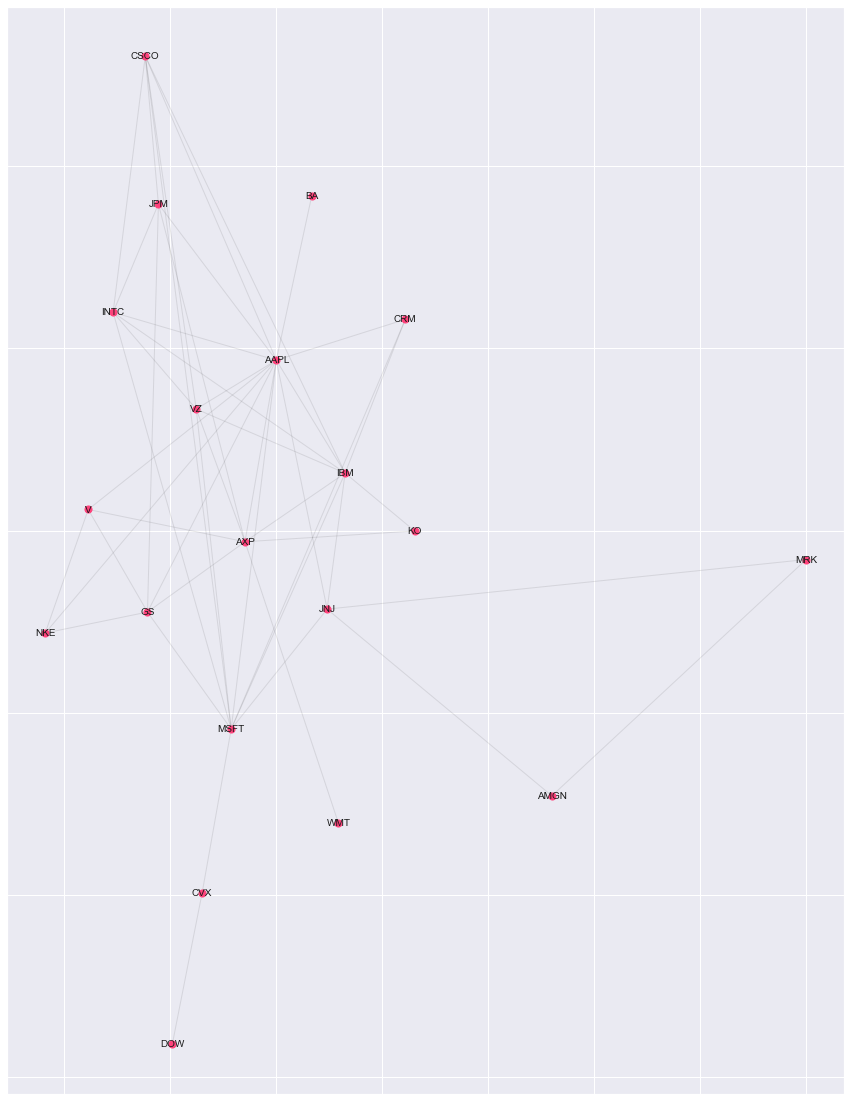

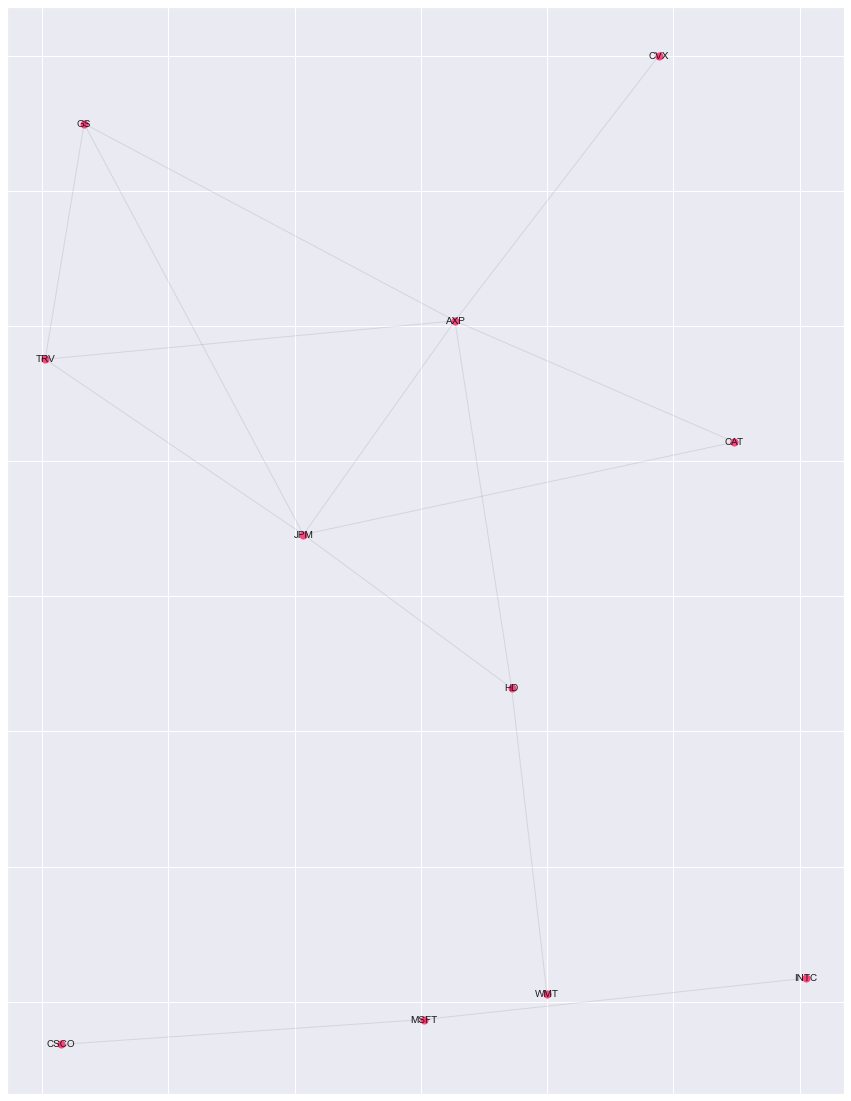

In [157]:
graph = [gr_news,gr_price]
node_labels = {} 
for G in graph:
    pos = nx.kamada_kawai_layout(G)
    nodes = G.nodes()
    fig, axs = plt.subplots(1, 1, figsize=(15,20))

    el = nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axs)
    nl = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='#FF427b', 
                                node_size=50, ax=axs)
    ll = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
   
    #createdictionary of nodes and labels
    for node in G.nodes():
        #set the node name as the key and the label as its value 
        node_labels[node] = node
   
  



#5. Find Subgraphs

100%|██████████| 11/11 [00:00<?, ?it/s]


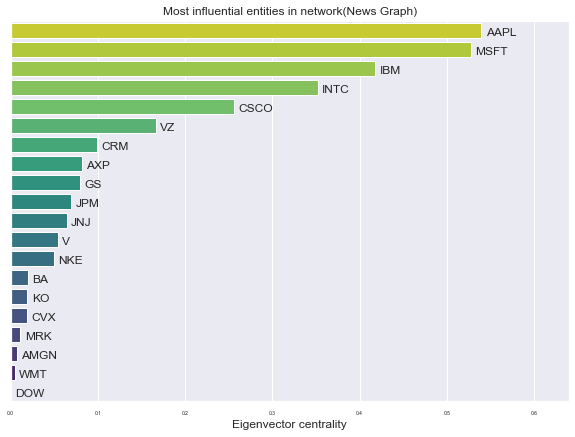

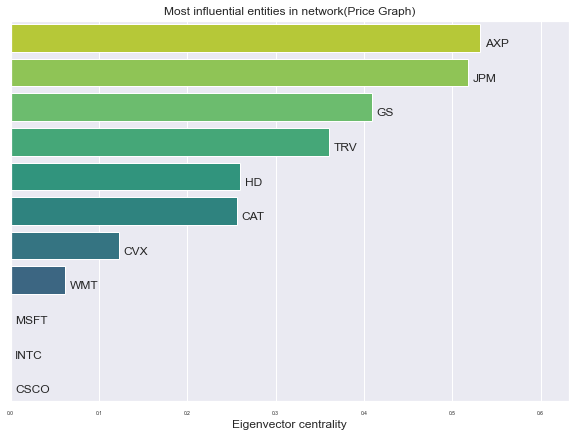

In [148]:
txt ="(News Graph)"
for G in graph:
    
    nodes = []
    eigenvector_cents = []
    ec_dict = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
    for node in tqdm(G.nodes()):
      nodes.append(node)
      eigenvector_cents.append(ec_dict[node])

    df_centralities = pd.DataFrame(data={'entity': nodes,
                                        'eigenvector': eigenvector_cents})

    df_cent_top = df_centralities.sort_values('eigenvector', ascending=False).head(20)
    df_cent_top.reset_index(inplace=True, drop=True)
    fig, axs = plt.subplots(figsize=(10,7))
    g = sns.barplot(data=df_cent_top,
                x='eigenvector',
                y='entity',
                dodge=False,
                orient='h',
                hue='eigenvector',
                palette='viridis',)

    g.set_yticks([])
    g.set_title('Most influential entities in network'+txt)
    g.set_xlabel('Eigenvector centrality')
    g.set_ylabel('')
    g.set_xlim(0, max(df_cent_top['eigenvector'])+0.1)
    g.legend_.remove()
    g.tick_params(labelsize=5)

    for i in df_cent_top.index:
        g.text(df_cent_top.iloc[i]['eigenvector']+0.005, i+0.25, df_cent_top.iloc[i]['entity'])

    #sns.despine()
    g.get_figure().savefig('cent_plot.png', dpi=1000)
    txt ="(Price Graph)"
    nodes = []
    eigenvector_cents=[]


#6. Cliques

Finding the optimal number


In [141]:
from networkx.algorithms.community.kclique import k_clique_communities

100%|██████████| 28/28 [00:00<00:00, 26185.18it/s]


[3, 2]

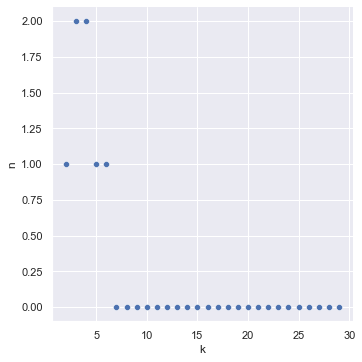

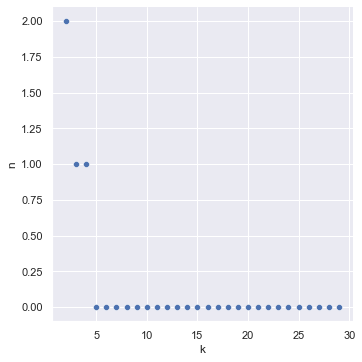

In [263]:
#Explore what the clique size per the nunmber of cliques for each graoh
clique_sizes = range(2, 30)
optimal_clique = [] #will hold the optimal clique size for each graph
for G in graph:
  n_cliques = []
  for k in tqdm(clique_sizes):
    n_cliques.append(len(list(k_clique_communities(G, k))))

  optimal_clique.append(2+(n_cliques.index(max(n_cliques)))) #clique sizes should be greater than one, hence least clique size is 2
 
  df_relplot = pd.DataFrame(data={'k': clique_sizes,
                                  'n': n_cliques})
  
  sns.relplot(data=df_relplot,
              x='k',
              y='n')

In [270]:
#General cliques using optimal minimum clique size array

cliques=[]
num=0
for G in graph:
    cliques.append(list(k_clique_communities(G, optimal_clique[num])))
    num+=1

Find centralities in cliques

In [274]:
#Find centralities within each clique
clx=[]
num = 0
for G in graph:
    eigenvector_cents = []
    entities = []
    clique_ids = []
    for id, clique in enumerate(cliques[num]):
      sg = G.subgraph(list(clique))

      nodes = sg.nodes()

      clique_ids.extend(np.repeat(id, len(nodes)))
      entities.extend(nodes)

      ec_dict = nx.eigenvector_centrality(sg, max_iter=1000, weight='weight')

      for entity in nodes:
        eigenvector_cents.append(ec_dict[entity])
    df_cliques = pd.DataFrame(data={
        'clique': clique_ids,
        'entity': entities,
        'centrality': eigenvector_cents
    })
    clx.append(df_cliques)
    num+=1
clx #index 0 = news graph, index 1 = price/vol graph

[    clique entity  centrality
 0        0    MRK    0.637223
 1        0   AMGN    0.530391
 2        0    JNJ    0.559135
 3        1   AAPL    0.539686
 4        1    AXP    0.081683
 5        1    CRM    0.098875
 6        1   CSCO    0.255944
 7        1     GS    0.079270
 8        1    IBM    0.418603
 9        1   INTC    0.352819
 10       1    JNJ    0.061870
 11       1    JPM    0.069478
 12       1   MSFT    0.527858
 13       1    NKE    0.049969
 14       1      V    0.053849
 15       1     VZ    0.166527
 16       1     KO    0.019303,
     clique entity  centrality
 0        0   CSCO    0.484978
 1        0   MSFT    0.707107
 2        0   INTC    0.514583
 3        1    AXP    0.531801
 4        1    CAT    0.255949
 5        1    CVX    0.122908
 6        1     GS    0.408848
 7        1     HD    0.259892
 8        1    JPM    0.517761
 9        1    TRV    0.360472
 10       1    WMT    0.062080]

In [272]:
#Color pallete for cliques
col_pal = {0: '#F1E8F3',
           1: '#A8DDFF',
           2: '#FF8A5B',
           3: '#74D3AE',
           4: '#93B7BE',
           5: '#D1B1CB',
           6: '#BAF2BB',
           7: '#FFA69E',
           8: '#97EAD2',
           9: '#34E4EA',
           10: '#B95F89',
           99:'#828A95'}

Plot Cliques

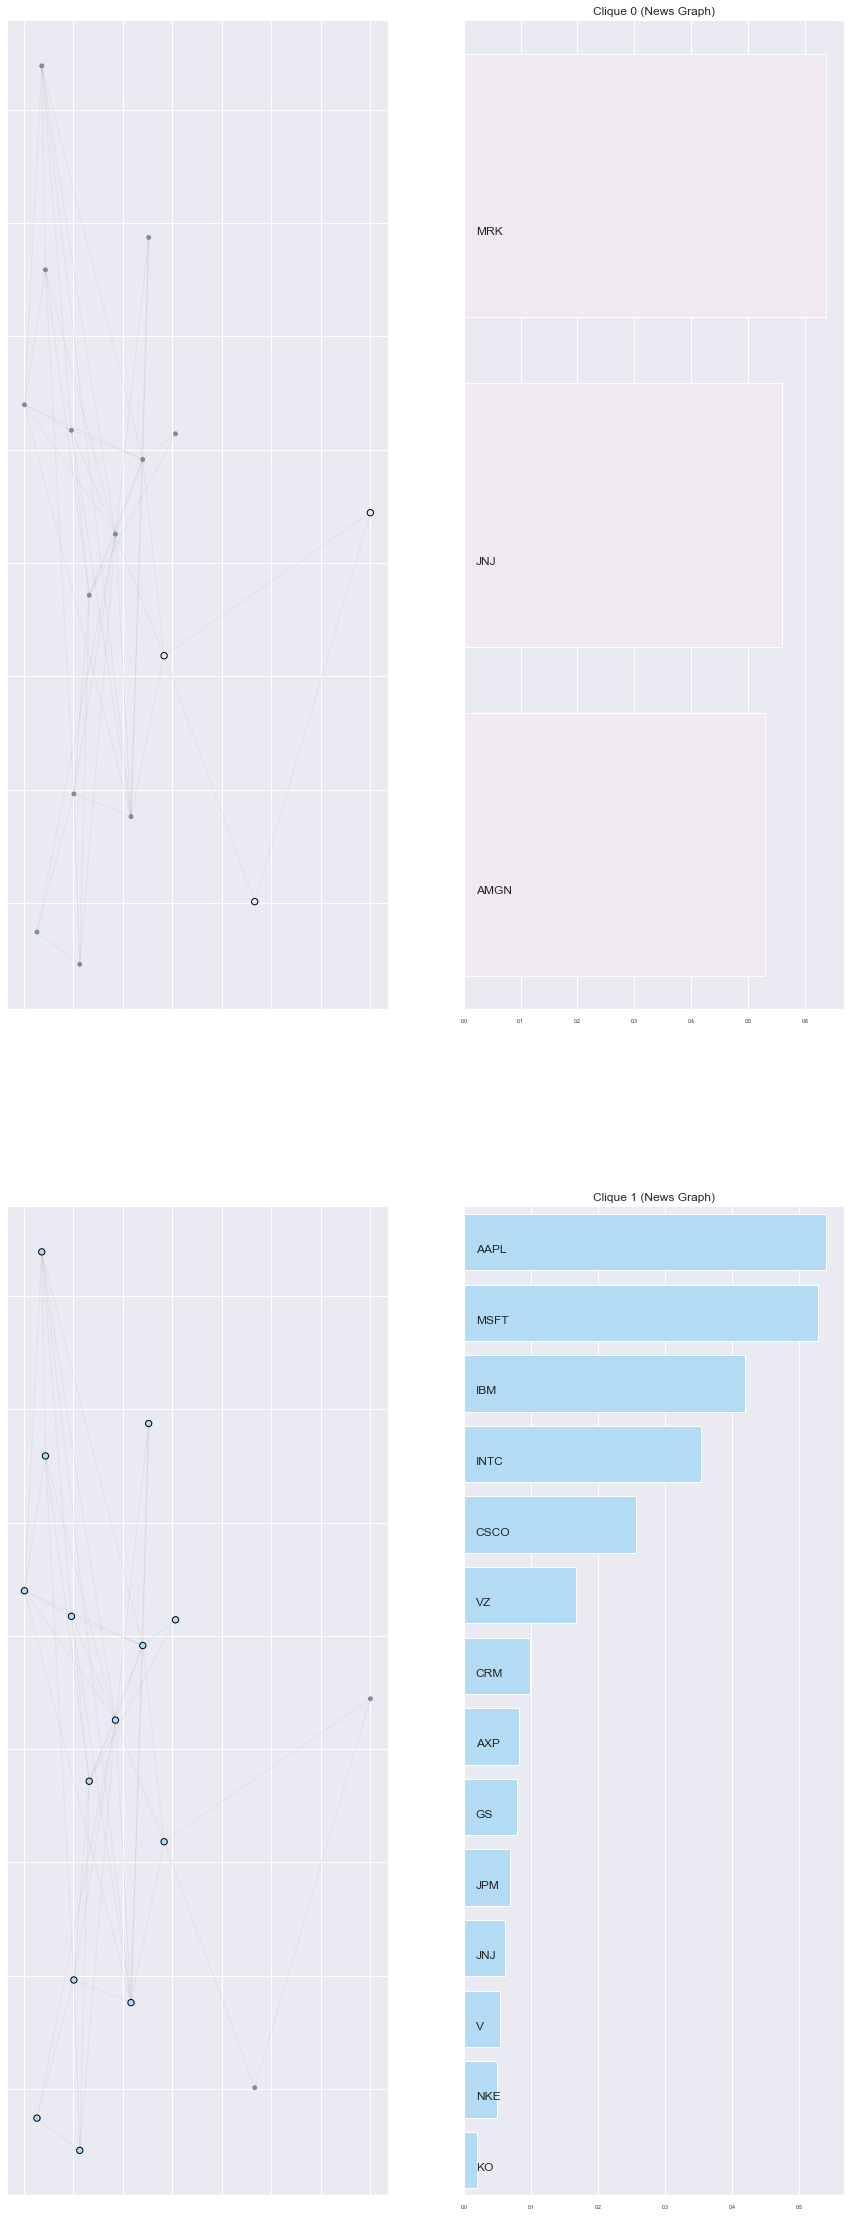

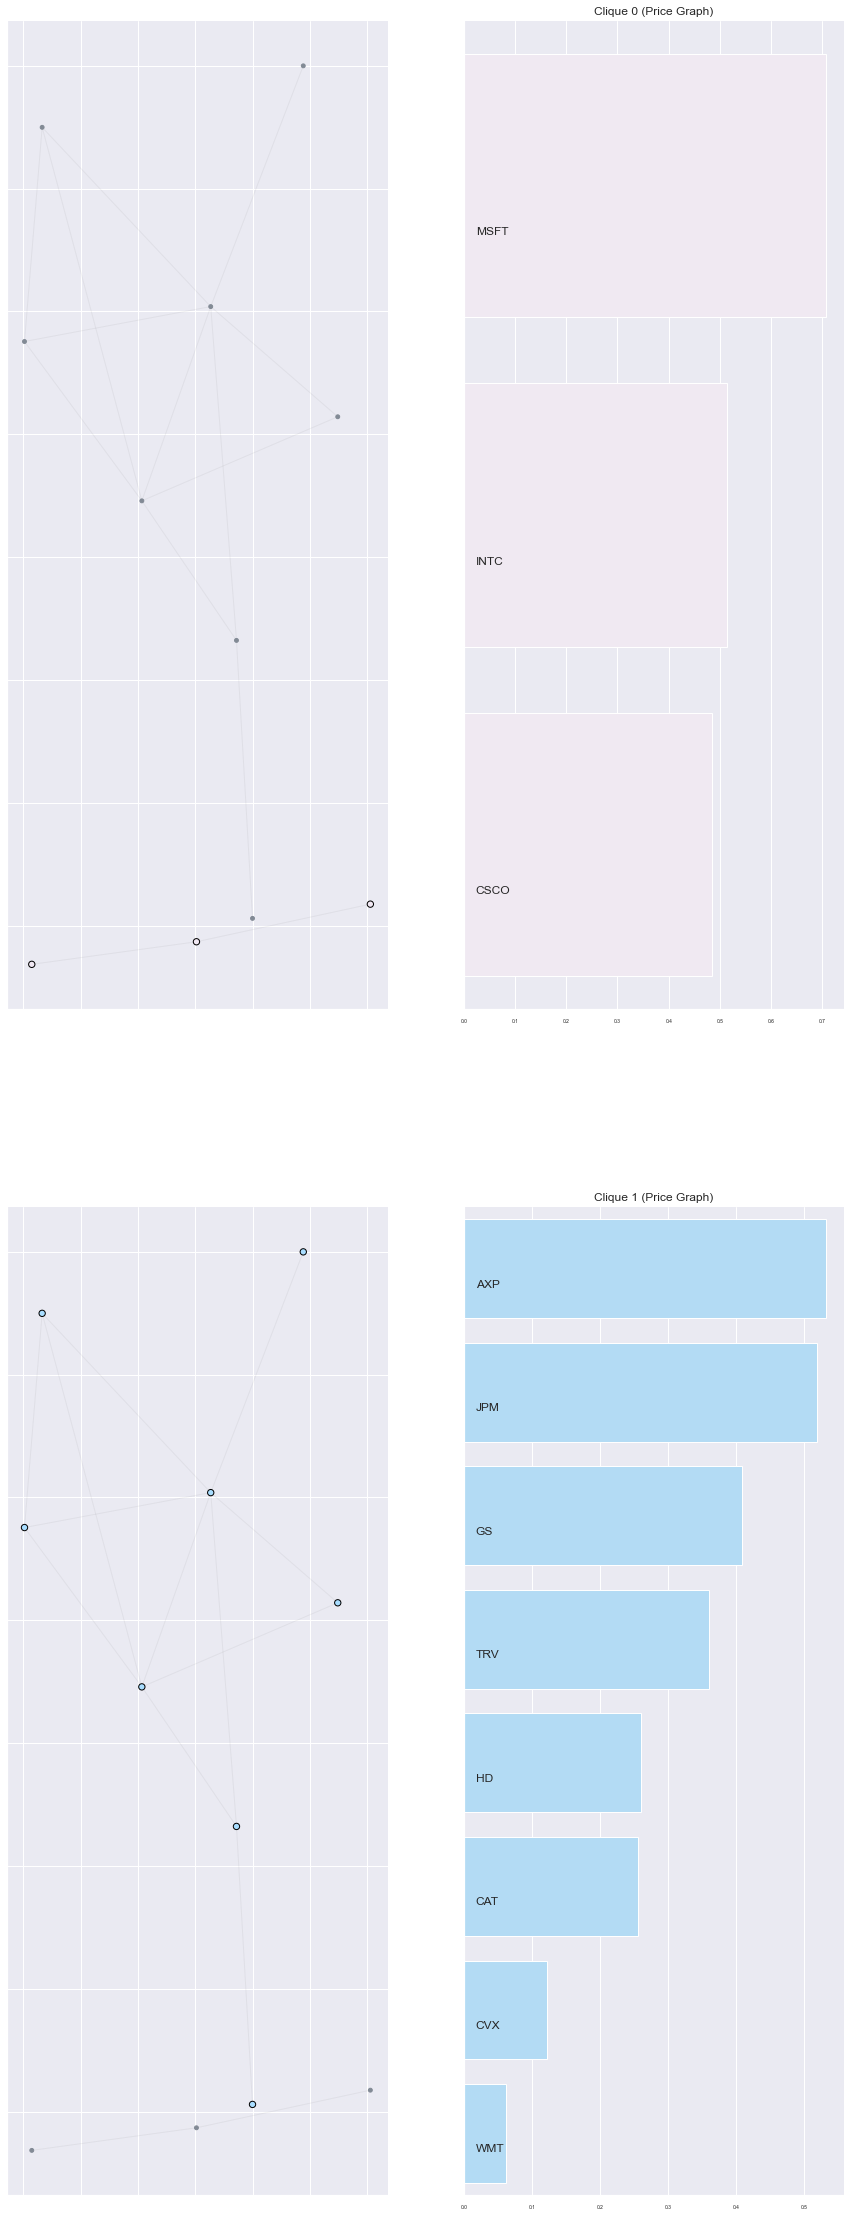

In [273]:
#Plot Cliques
clique_num=0
txt ="(News Graph)"
for G in graph:
   
    df_cliques = clx[clique_num]
    G_clique = G.subgraph(df_cliques['entity'].unique())
    pos = nx.kamada_kawai_layout(G_clique)
    nodes = G_clique.nodes()

    fig, axs = plt.subplots(max(df_cliques['clique'])+1, 2, figsize=(15,40))

    for clique in range(max(df_cliques['clique'])+1):
      node_colors = [col_pal[clique] if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]
      sizes = [40 if node in df_cliques[df_cliques['clique']==clique]['entity'].values else 15 for node in nodes]
      edge_colors = ['black' if node in df_cliques[df_cliques['clique']==clique]['entity'].values else col_pal[99] for node in nodes]

      ec = nx.draw_networkx_edges(G_clique, pos, alpha=0.05, ax=axs[clique, 0])
      nc = nx.draw_networkx_nodes(G_clique, pos, nodelist=nodes, node_color=node_colors, 
                                  node_size=sizes, ax=axs[clique, 0],
                                  edgecolors=edge_colors)
      
      df_clique_ind = df_cliques[df_cliques['clique']==clique]
      df_clique_ind = df_clique_ind.sort_values('centrality', ascending=False).head(15)
      df_clique_ind.reset_index(inplace=True, drop=True)

      g = sns.barplot(data=df_clique_ind,
                  x='centrality',
                  y='entity',
                  hue='clique',
                  palette=col_pal,
                  dodge=False,
                  orient='h',
                  ax=axs[clique, 1])
      
      g.set_yticks([])
      g.set_title(f'Clique {clique} {txt}')
      g.set_xlabel('')
      g.set_ylabel('')
      g.legend_.remove()
      g.tick_params(labelsize=5)
      

      for i in df_clique_ind.index:
        g.text(max(df_clique_ind['centrality'])/30, i+0.15, df_clique_ind.iloc[i]['entity'])

    txt ="(Price Graph)"  
    clique_num = clique_num+1
    sns.despine()


#4 Implement Multiplex Graph

milk


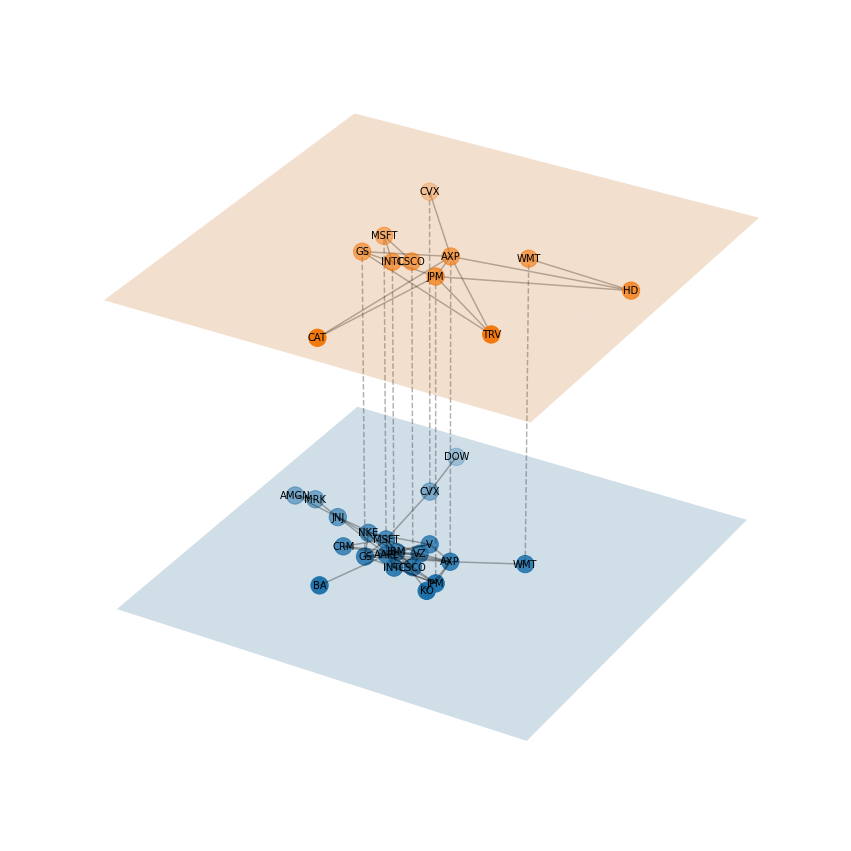

In [53]:
#install recommended packages
from LayeredNetworkGraph import LayeredNetworkGraph

# initialise figure and plot
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph([G,G2], node_labels=node_labels ,ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()
fig.savefig('graph_images/multilayered.png', dpi=1000)
 